<a href="https://colab.research.google.com/github/crisnandrarm/Text-Mining/blob/main/Text_Mining_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Text Mining (Case Study: Hate Speech Detection)**


## **Dataset Description**

The dataset is a two columns data of: label - tweet, consist of 713 tweets in Indonesian.

The label is Non_HS or HS. Non_HS for "non-hate-speech" tweet and HS for "hate-speech" tweet.

- Number of Non_HS tweets: 453
- Number of HS tweets: 260



##### **Data Source:**

[Ika Alfina, Rio Mulia, Mohamad Ivan Fanany, and Yudo Ekanata, "Hate Speech Detection in Indonesian Language: A Dataset and Preliminary Study ", in Proceeding of 9th International Conference on Advanced Computer Science and Information Systems 2017(ICACSIS 2017)](https://www.researchgate.net/publication/320131169_Hate_Speech_Detection_in_the_Indonesian_Language_A_Dataset_and_Preliminary_Study
)

## **Analysis with Python Code**

### **Import Library**


In [1]:
# Library for dataset
import pandas as pd
import numpy as np

# Library for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

# Library for preprocessing
import re
import nltk
from nltk.corpus import stopwords
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import LabelEncoder


#Library for classification
from sklearn.naive_bayes import GaussianNB 
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import LogisticRegression

#Library for Evaluation
from sklearn import metrics
from sklearn.metrics import classification_report
from mlxtend.plotting import plot_confusion_matrix



/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning:

The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning:

The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.



In [2]:
# ! pip3 install Sastrawi
# nltk.download('punkt')
# nltk.download('stopwords')

### **Dataset**


In [3]:
df = pd.read_csv('https://raw.githubusercontent.com/ialfina/id-hatespeech-detection/master/IDHSD_RIO_unbalanced_713_2017.txt', sep='\t', encoding = "ISO-8859-1", dtype=str)
df.head()

,Label,Tweet
0,Non_HS,RT @spardaxyz: Fadli Zon Minta Mendagri Segera...
1,Non_HS,RT @baguscondromowo: Mereka terus melukai aksi...
2,Non_HS,Sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"Ahmad Dhani Tak Puas Debat Pilkada, Masalah Ja..."
4,Non_HS,RT @lisdaulay28: Waspada KTP palsu.....kawal P...


In [4]:
count_label =df.Label.value_counts().to_frame()
px.bar(data_frame=count_label, x=count_label.index , y='Label')

Dari barchart diatas, dataset yang digunakan memiliki imbalance data label, sehingga pada tahap preprocessing akan dilakukan SMOTE untuk menanggulangi data yang tidak seimbang

### **Preprocessing**

#### Case Folding


In [5]:
def case_fold(data):
    return data.str.lower()

In [6]:
df['Tweet'] = case_fold(df['Tweet'])
df.head()

,Label,Tweet
0,Non_HS,rt @spardaxyz: fadli zon minta mendagri segera...
1,Non_HS,rt @baguscondromowo: mereka terus melukai aksi...
2,Non_HS,sylvi: bagaimana gurbernur melakukan kekerasan...
3,Non_HS,"ahmad dhani tak puas debat pilkada, masalah ja..."
4,Non_HS,rt @lisdaulay28: waspada ktp palsu.....kawal p...


#### Data Cleaning

In [7]:
def clean(data):
  tweets = []
  for tweet in data:
      tweet = re.sub(r"(?:\@|https?\://)\S+", "", tweet)
      tweet = re.sub(r"http\S+", "", tweet)
      tweet = re.sub('\n', '', tweet)
      tweet = re.sub('rt', '', tweet)
      tweet = re.sub("[^a-zA-Z^']", " ", tweet)
      tweet = re.sub(" {2,}", " ", tweet)
      tweet = tweet.strip()
      tweets.append(tweet)
  return tweets

In [8]:
df_clean = df.copy()
df_clean['Tweet']= clean(df['Tweet'])
df_clean.head()

,Label,Tweet
0,Non_HS,fadli zon minta mendagri segera menonaktifkan ...
1,Non_HS,mereka terus melukai aksi dalam rangka memenja...
2,Non_HS,sylvi bagaimana gurbernur melakukan kekerasan ...
3,Non_HS,ahmad dhani tak puas debat pilkada masalah jal...
4,Non_HS,waspada ktp palsu kawal pilkada


#### Tokenization


In [9]:
def token(data):
  return data.apply(nltk.word_tokenize)

In [10]:
df_clean['Tweet'] = token(df_clean['Tweet'])
df_clean.head()

,Label,Tweet
0,Non_HS,"[fadli, zon, minta, mendagri, segera, menonakt..."
1,Non_HS,"[mereka, terus, melukai, aksi, dalam, rangka, ..."
2,Non_HS,"[sylvi, bagaimana, gurbernur, melakukan, keker..."
3,Non_HS,"[ahmad, dhani, tak, puas, debat, pilkada, masa..."
4,Non_HS,"[waspada, ktp, palsu, kawal, pilkada]"


#### Stopword


In [11]:
def stop_words(data) :
  stop_words = set(stopwords.words('indonesian'))
  return data.apply(lambda x: [item for item in x if item not in stop_words])

In [12]:
df_clean["Tweet"] = stop_words(df_clean['Tweet'])
df_clean.head()

,Label,Tweet
0,Non_HS,"[fadli, zon, mendagri, menonaktifkan, ahok, gu..."
1,Non_HS,"[melukai, aksi, rangka, memenjarakan, ahok, ah..."
2,Non_HS,"[sylvi, gurbernur, kekerasan, perempuan, bukti..."
3,Non_HS,"[ahmad, dhani, puas, debat, pilkada, jalan, be..."
4,Non_HS,"[waspada, ktp, palsu, kawal, pilkada]"


#### Stemming


In [13]:
def stem(data):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  return data.apply(lambda x: [ stemmer.stem(item) for item in x])

In [14]:
df_clean["Tweet"] = stem(df_clean["Tweet"])
df_clean.head()

,Label,Tweet
0,Non_HS,"[fadli, zon, mendagri, nonaktif, ahok, gubernu..."
1,Non_HS,"[luka, aksi, rangka, penjara, ahok, ahok, gaga..."
2,Non_HS,"[sylvi, gurbernur, keras, perempuan, bukti, fo..."
3,Non_HS,"[ahmad, dhani, puas, debat, pilkada, jalan, be..."
4,Non_HS,"[waspada, ktp, palsu, kawal, pilkada]"


In [15]:
df_clean['Tweet'] = df_clean["Tweet"].apply(lambda x: " ".join(x) if isinstance(x, list) else x)
df_clean.head()

,Label,Tweet
0,Non_HS,fadli zon mendagri nonaktif ahok gubernur dki
1,Non_HS,luka aksi rangka penjara ahok ahok gagal pilkada
2,Non_HS,sylvi gurbernur keras perempuan bukti foto bar...
3,Non_HS,ahmad dhani puas debat pilkada jalan bekas ungkap
4,Non_HS,waspada ktp palsu kawal pilkada


In [16]:
df_clean['Tweet'][0]

'fadli zon mendagri nonaktif ahok gubernur dki'

#### TF-IDF


In [17]:
def tf_idf(data):
  vectorizer = TfidfVectorizer()
  return vectorizer.fit_transform(data)


In [18]:
x = tf_idf(df_clean['Tweet'])
label = np.array(df_clean['Label'].values)

#### SMOTE

In [19]:
sampler = SMOTE()
x, label = sampler.fit_resample(x,label)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.



In [20]:
Label = pd.DataFrame(data=label, columns=['label'])

In [21]:
count_label = Label['label'].value_counts().to_frame()
px.bar(data_frame=count_label, x=count_label.index , y='label')

####Split Train-Test

In [61]:
X_train, X_test, y_train, y_test = train_test_split(x, label, test_size=0.25, random_state=1)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(679, 2129)
(227, 2129)
(679,)
(227,)


In [62]:
lb_make = LabelEncoder()
y_train = lb_make.fit_transform(y_train)
print(y_train.shape)

(679,)


In [63]:
y_test = lb_make.fit_transform(y_test)
print(y_test.shape)

(227,)


### **Classification**


#### **Naive Bayes**


##### **Train**

In [65]:
# Modeling Naive Bayes Classifier
gnb = GaussianNB()
gnb.fit(X_train.toarray(), y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

##### **Test**

In [66]:
y_pred_nb= gnb.predict(X_test.toarray())
# y_pred_nb

##### **Evaluation**

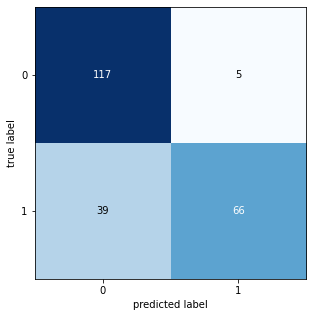

In [67]:
#Show the Confussion Matrix
cm1 = metrics.confusion_matrix(y_test, y_pred_nb)
plot_confusion_matrix(cm1, figsize=(5,5))
plt.show()

In [68]:
print(classification_report(y_test, y_pred_nb))

              precision    recall  f1-score   support

           0       0.75      0.96      0.84       122
           1       0.93      0.63      0.75       105

    accuracy                           0.81       227
   macro avg       0.84      0.79      0.80       227
weighted avg       0.83      0.81      0.80       227



#### **SVM**


##### **Train**

In [97]:
svm = SVC(kernel='rbf', probability=True)
svm.fit(X_train.toarray(), y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

##### **Test**

In [98]:
y_pred_svm = svm.predict(X_test.toarray())
# y_pred_svm

##### **Evaluation**

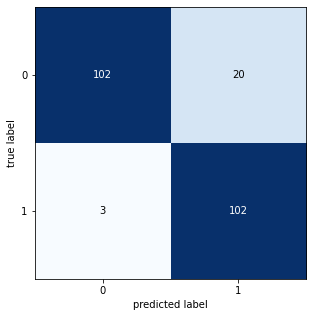

In [99]:
#Show the Confussion Matrix
cm1 = metrics.confusion_matrix(y_test, y_pred_svm)
plot_confusion_matrix(cm1, figsize=(5,5))
plt.show()

In [100]:
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.97      0.84      0.90       122
           1       0.84      0.97      0.90       105

    accuracy                           0.90       227
   macro avg       0.90      0.90      0.90       227
weighted avg       0.91      0.90      0.90       227



#### **ANN**


##### **Train**

In [73]:
mlp = MLPClassifier(random_state=1, max_iter=300)
mlp.fit(X_train.toarray(), y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100,), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=1, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

##### **Test**

In [74]:
y_pred_ann = mlp.predict(X_test.toarray())
# y_pred_ann

##### **Evaluation**

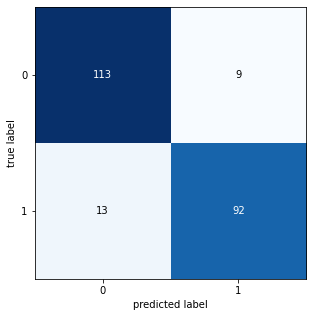

In [75]:
#Show the Confussion Matrix
cm1 = metrics.confusion_matrix(y_test, y_pred_ann)
plot_confusion_matrix(cm1, figsize=(5,5))
plt.show()

In [76]:
print(classification_report(y_test, y_pred_ann))

              precision    recall  f1-score   support

           0       0.90      0.93      0.91       122
           1       0.91      0.88      0.89       105

    accuracy                           0.90       227
   macro avg       0.90      0.90      0.90       227
weighted avg       0.90      0.90      0.90       227



#### **KNN**


##### **Train**

In [77]:
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train.toarray(), y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

##### **Test**

In [78]:
y_pred_knn = knn.predict(X_test.toarray())
# y_pred_knn

##### **Evaluation**

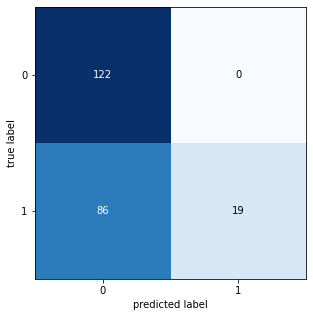

In [79]:
#Show the Confussion Matrix
cm1 = metrics.confusion_matrix(y_test, y_pred_knn)
plot_confusion_matrix(cm1, figsize=(5,5))
plt.show()

In [80]:
print(classification_report(y_test, y_pred_knn))

              precision    recall  f1-score   support

           0       0.59      1.00      0.74       122
           1       1.00      0.18      0.31       105

    accuracy                           0.62       227
   macro avg       0.79      0.59      0.52       227
weighted avg       0.78      0.62      0.54       227



#### **Random Forest**


##### **Train**

In [81]:
n = [10,20,30,40,50,60,70,80,90,100,110,120,130,140,150,160,170,180,190,200]

random_grid = {'n_estimators': n}
# Create a based model
rf = RandomForestClassifier()

# Instantiate the grid search model
rf_randoms = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                               cv = 6, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_randoms.fit(X_test.toarray(), y_test)

Fitting 6 folds for each of 20 candidates, totalling 120 fits


/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning:

The total space of parameters 20 is smaller than n_iter=100. Running 20 iterations. For exhaustive searches, use GridSearchCV.

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  83 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 120 out of 120 | elapsed:   23.5s finished


RandomizedSearchCV(cv=6, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [82]:
print("Jumlah Pohon Optimal:") # print best parameter after tuning 
print(rf_randoms.best_params_)
print("Parameter Lain yang Digunakan:") # Print how our model looks after hyper-parameter tuning 
print(rf_randoms.best_estimator_)

Jumlah Pohon Optimal:
{'n_estimators': 40}
Parameter Lain yang Digunakan:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)


In [83]:
#Modeling Random Forest
rf = RandomForestClassifier(n_estimators=50, random_state=0)
rf.fit(X_train.toarray(), y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

##### **Test**

In [84]:
y_pred_rf= rf.predict(X_test)
# y_pred_rf

##### **Evaluation**

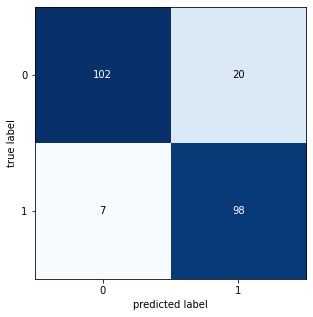

In [85]:
#Show the Confussion Matrix
cm1 = metrics.confusion_matrix(y_test, y_pred_rf)
plot_confusion_matrix(cm1, figsize=(5,5))
plt.show()

In [86]:
print(classification_report(y_test, y_pred_rf))

              precision    recall  f1-score   support

           0       0.94      0.84      0.88       122
           1       0.83      0.93      0.88       105

    accuracy                           0.88       227
   macro avg       0.88      0.88      0.88       227
weighted avg       0.89      0.88      0.88       227



#### **Logistic Regression**


##### **Train**

In [87]:
logreg = LogisticRegression().fit(X_train.toarray(), y_train)

##### **Test**

In [88]:
y_pred_log= logreg.predict(X_test.toarray())
# y_pred_log

##### **Evaluation**

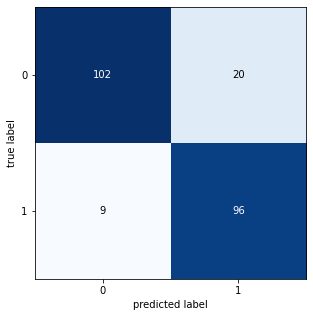

In [89]:
#Show the Confussion Matrix
cm1 = metrics.confusion_matrix(y_test, y_pred_log)
plot_confusion_matrix(cm1, figsize=(5,5))
plt.show()

In [90]:
print(classification_report(y_test, y_pred_log))

              precision    recall  f1-score   support

           0       0.92      0.84      0.88       122
           1       0.83      0.91      0.87       105

    accuracy                           0.87       227
   macro avg       0.87      0.88      0.87       227
weighted avg       0.88      0.87      0.87       227



### **Model Comparison**

In [101]:
# Comparing Model Performance
print("KNN Accuracy =", metrics.accuracy_score(y_test, y_pred_knn))
print("KNN Precision =", metrics.precision_score(y_test, y_pred_knn))
print("KNN Recall =", metrics.recall_score(y_test, y_pred_knn))
print("KNN F1-Score =", metrics.f1_score(y_test, y_pred_knn))
print("_______________________")
print("Random Forest Accuracy =", metrics.accuracy_score(y_test, y_pred_rf))
print("Random Forest Precision =", metrics.precision_score(y_test, y_pred_rf))
print("Random Forest Recall =", metrics.recall_score(y_test, y_pred_rf))
print("Random Forest F1-Score =", metrics.f1_score(y_test, y_pred_rf))
print("_______________________")
print("Naive Bayes Accuracy =", metrics.accuracy_score(y_test, y_pred_nb))
print("Naive Bayes Precision =", metrics.precision_score(y_test, y_pred_nb))
print("Naive Bayes Recall =", metrics.recall_score(y_test, y_pred_nb))
print("Naive Bayes F1-Score =", metrics.f1_score(y_test, y_pred_nb))
print("_______________________")
print("Logistic Regression Accuracy =", metrics.accuracy_score(y_test, y_pred_log))
print("Logistic Regression Precision =", metrics.precision_score(y_test, y_pred_log))
print("Logistic Regression Recall =", metrics.recall_score(y_test, y_pred_log))
print("Logistic Regression F1-Score =", metrics.f1_score(y_test, y_pred_log))
print("_______________________")
print("ANN Accuracy =", metrics.accuracy_score(y_test, y_pred_ann))
print("ANN Precision =", metrics.precision_score(y_test, y_pred_ann))
print("ANN Recall =", metrics.recall_score(y_test, y_pred_ann))
print("ANN F1-Score =", metrics.f1_score(y_test, y_pred_ann))
print("_______________________")
print("SVM Accuracy =", metrics.accuracy_score(y_test, y_pred_svm))
print("SVM Precision =", metrics.precision_score(y_test, y_pred_svm))
print("SVM Recall =", metrics.recall_score(y_test, y_pred_svm))
print("SVM F1-Score =", metrics.f1_score(y_test, y_pred_svm))

KNN Accuracy = 0.6211453744493393
KNN Precision = 1.0
KNN Recall = 0.18095238095238095
KNN F1-Score = 0.3064516129032258
_______________________
Random Forest Accuracy = 0.8810572687224669
Random Forest Precision = 0.8305084745762712
Random Forest Recall = 0.9333333333333333
Random Forest F1-Score = 0.8789237668161435
_______________________
Naive Bayes Accuracy = 0.8061674008810573
Naive Bayes Precision = 0.9295774647887324
Naive Bayes Recall = 0.6285714285714286
Naive Bayes F1-Score = 0.75
_______________________
Logistic Regression Accuracy = 0.8722466960352423
Logistic Regression Precision = 0.8275862068965517
Logistic Regression Recall = 0.9142857142857143
Logistic Regression F1-Score = 0.8687782805429863
_______________________
ANN Accuracy = 0.9030837004405287
ANN Precision = 0.9108910891089109
ANN Recall = 0.8761904761904762
ANN F1-Score = 0.8932038834951457
_______________________
SVM Accuracy = 0.8986784140969163
SVM Precision = 0.8360655737704918
SVM Recall = 0.9714285714285

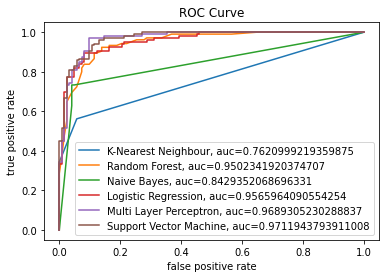

In [104]:
y_pred_knn_proba = knn.predict_proba(X_test.toarray())[::,1]
fprknn, tprknn, _ = metrics.roc_curve(y_test,  y_pred_knn_proba)
aucknn = metrics.roc_auc_score(y_test, y_pred_knn_proba)

y_pred_rf_proba = rf.predict_proba(X_test.toarray())[::,1]
fprrf, tprrf, _ = metrics.roc_curve(y_test,  y_pred_rf_proba)
aucrf = metrics.roc_auc_score(y_test, y_pred_rf_proba)

y_pred_nb_proba = gnb.predict_proba(X_test.toarray())[::,1]
fprnb, tprnb, _ = metrics.roc_curve(y_test,  y_pred_nb_proba)
aucnb = metrics.roc_auc_score(y_test, y_pred_nb_proba)

y_pred_log_proba = logreg.predict_proba(X_test.toarray())[::,1]
fprlog, tprlog, _ = metrics.roc_curve(y_test,  y_pred_log_proba)
auclog = metrics.roc_auc_score(y_test, y_pred_log_proba)

y_pred_ann_proba = mlp.predict_proba(X_test.toarray())[::,1]
fprann, tprann, _ = metrics.roc_curve(y_test,  y_pred_ann_proba)
aucann = metrics.roc_auc_score(y_test, y_pred_ann_proba)

y_pred_svm_proba = svm.predict_proba(X_test.toarray())[::,1]
fprsvm, tprsvm, _ = metrics.roc_curve(y_test,  y_pred_svm_proba)
aucsvm = metrics.roc_auc_score(y_test, y_pred_svm_proba)

# Comparing ROC Curves
plt.plot(fprknn,tprknn,label="K-Nearest Neighbour, auc="+str(aucknn))
plt.plot(fprrf,tprrf,label="Random Forest, auc="+str(aucrf))
plt.plot(fprnb,tprnb,label="Naive Bayes, auc="+str(aucnb))
plt.plot(fprlog,tprlog,label="Logistic Regression, auc="+str(auclog))
plt.plot(fprann,tprann,label="Multi Layer Perceptron, auc="+str(aucann))
plt.plot(fprsvm,tprsvm,label="Support Vector Machine, auc="+str(aucsvm))
plt.title('ROC Curve')
plt.xlabel('false positive rate') 
plt.ylabel('true positive rate')
plt.legend(loc=4)
plt.show()